<a href="https://colab.research.google.com/github/jmhuer/Fall2021MusicResearch/blob/main/HarmonyReductionAndDecompostion/pytorch_AEwLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pretty_midi
# !git clone https://github.com/jmhuer/ModularSparseAutoencoder
# !git clone https://github.com/music-x-lab/POP909-Dataset
!git clone https://github.com/jmhuer/HT
# !git clone https://github.com/Tsung-Ping/functional-harmony
# %cd /content/POP909-Dataset/data_process
!pip install libfmp

     |████████████████████████████████| 5.6 MB 11.4 MB/s 
     |████████████████████████████████| 51 kB 8.0 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591953 sha256=72b141665692614d87e3b6154a3ec0164cc00dd30ef45cbb6c3524ba2674f6f8
  Stored in directory: /root/.cache/pip/wheels/ad/74/7c/a06473ca8dcb63efb98c1e67667ce39d52100f837835ea18fa
Successfully built pretty-midi
Cloning into 'HT'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 32 (delta 14), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (32/32), done.
Cloning into 'functional-harmony'...
remote: Enumerating objects: 460, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 460 (delta 13), reused 49 (delta 12), pack-reused 396
Receiving objects: 100% (460/460), 2.50 MiB | 27.51 MiB/s, done.
Resolving deltas: 100% (

#Download Data

In [3]:
from HT.BPS_FH_preprocessing import main

main()

Message: load note data ...
lowest pitch = 24 highest pitch =  101
Message: load chord labels...
Message: get framewise labels ...
max_length = 8482
min_length = 872
keys in corpus['op'] = dict_keys(['pianoroll', 'chromagram', 'start_time', 'label'])
label fields =  [('op', '<U10'), ('onset', '<f8'), ('key', '<U10'), ('degree1', '<U10'), ('degree2', '<U10'), ('quality', '<U10'), ('inversion', '<i8'), ('rchord', '<U10'), ('root', '<U10'), ('tquality', '<U10'), ('chord_change', '<i8')]
Running Message: augment data...
keys in corpus_aug['shift_id']['op'] = dict_keys(['pianoroll', 'tonal_centroid', 'start_time', 'label'])
Running Message: reshape data...
keys in corpus_aug_reshape['shift_id']['op'] = dict_keys(['pianoroll', 'tonal_centroid', 'start_time', 'label', 'len'])
sequence_len_non_overlaped = [17, 22, 23, 24, 30, 34, 36, 40, 44, 48, 52, 53, 66, 72, 80, 84, 86, 88, 100, 102, 104, 116, 118, 120, 128]
sequence_len_overlaped = [17, 22, 23, 24, 30, 34, 36, 40, 44, 48, 52, 53, 66, 72, 8

In [233]:
# !pip install tensorflow-gpu==1.15
from HT.chord_symbol_recognition import train_HT
from collections import Counter, namedtuple
from HT.BPS_FH_preprocessing import main
from HT.chord_symbol_recognition import load_data_symbol
#

import pickle
import os
import sys
# import utils
import pretty_midi 
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch


class BPS(Dataset):
    def __init__(self, data):
        "todo: transpose"
        self.all_data = []
        temp = []
        self.label = []
        temp2 = []
        self.chord_change = []
        temp3 = []      
        i = 0 
        for pi,chord, cc in zip(data["pianoroll"],data["tchord"],data['label']['chord_change']):
            temp.append(torch.tensor(pi[None,:,12:76]).double())
            temp2.append(torch.tensor(chord).double())
            temp3.append(torch.tensor(cc).double())
            i+=1
            if i > 30000: break
        self.all_data = torch.stack(temp).permute(0,1,3,2)
        self.label = torch.stack(temp2)
        self.chord_change = torch.stack(temp3)
        print("data" , self.all_data.shape)
        print("label" , self.label.shape)
        ##time.sleep(120)
        self.transform = self.make_transform()
    def __len__(self):
        return len(self.all_data)
    def __getitem__(self, idx):
        piano_roll_slice = self.all_data[idx,:,:]
        label_slice = self.label[idx]
        chord_change_slice = self.chord_change[idx]
        tranformed_piano_roll_slice = self.transform["norm"](piano_roll_slice)
        #print(tranformed_piano_roll_slice.shape)
        #print("label_slice", label_slice)
        return tranformed_piano_roll_slice, label_slice, chord_change_slice
    def make_transform(self):
        mean = self.all_data.mean()
        std = self.all_data.std() * 2
        print("mean ", mean)
        print("std ", std)
        tensor_transform = {
          'norm':
              transforms.Compose([
                  transforms.Normalize([mean], [std])  # Imagenet standards
              ]),
          "inverse_norm":
                transforms.Normalize(
                  mean= [-m/s for m, s in zip([mean], [std])],
                  std= [1/s for s in [std]]
                )
            }
        return tensor_transform


def load_data(train_data, test_data,  num_workers=0, batch_size=16, random_seed = 40):
    '''
    this data loading proccedure assumes dataset/train/ dataset/val/ folders
    also assumes transform dictionary with train and val
    '''
    dataset_train = BPS(train_data) 
    dataset_val = BPS(test_data) 

    print("Size of train dataset: ",len(dataset_train))
    print("Size of val dataset: ",len(dataset_val))

    dataloaders = {
        'train': DataLoader(dataset_train, batch_size=batch_size, shuffle=False, drop_last=True),
        'val': DataLoader(dataset_val, batch_size=batch_size, shuffle=False, drop_last=True)
    }
    return dataloaders



##only tensor transforms

dir='/content/BPS_FH_preprocessed_data_MIREX_Mm.pickle'
test_set_id = 1

train_data, test_data = load_data_symbol(dir=dir, 
                                         test_set_id=test_set_id, 
                                         sequence_with_overlap=True)


print("\n\nload_data_symbol train_data size: {}".format(train_data["tchord"].shape))

dataset = load_data(train_data, test_data, batch_size=40)

Load chord symbol data...
test_set_id = 1
keys in corpus_aug_reshape['shift_id']['op'] = dict_keys(['pianoroll', 'tonal_centroid', 'start_time', 'label', 'len'])
shift_list = ['shift_-1', 'shift_-2', 'shift_-3', 'shift_0', 'shift_1', 'shift_2', 'shift_3', 'shift_4', 'shift_5', 'shift_6']
train_op_list = ['2', '3', '4', '6', '7', '8', '10', '11', '12', '14', '15', '16', '18', '19', '20', '22', '23', '24', '26', '27', '28', '30', '31', '32']
test_op_list = ['1', '5', '9', '13', '17', '21', '25', '29']
train_data:  [('pianoroll', (54320, 128, 88)), ('tonal_centroid', (54320, 128, 6)), ('len', (54320,)), ('label', (54320, 128)), ('root', (54320, 128)), ('tquality', (54320, 128)), ('tchord', (54320, 128))]
test_data:  [('pianoroll', (294, 128, 88)), ('tonal_centroid', (294, 128, 6)), ('len', (294,)), ('label', (294, 128)), ('root', (294, 128)), ('tquality', (294, 128)), ('tchord', (294, 128))]
label fields: [('op', '<U10'), ('onset', '<f8'), ('key', '<U10'), ('degree1', '<U10'), ('degree2',

# Pretty MIDI helper functions

In [121]:
def piano_roll_to_pretty_midi(piano_roll, fs=8, program=0):
    '''Convert a Piano Roll array into a PrettyMidi object
     with a single instrument.
    Parameters
    ----------
    piano_roll : np.ndarray, shape=(128,frames), dtype=int
        Piano roll of one instrument
    fs : int
        Sampling frequency of the columns, i.e. each column is spaced apart
        by ``1./fs`` seconds.
    program : int
        The program number of the instrument.
    Returns
    -------
    midi_object : pretty_midi.PrettyMIDI
        A pretty_midi.PrettyMIDI class instance describing
        the piano roll.
    '''
    notes, frames = piano_roll.shape
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=program)

    # pad 1 column of zeros so we can acknowledge inital and ending events
    piano_roll = np.pad(piano_roll, [(0, 0), (1, 1)], 'constant')

    # use changes in velocities to find note on / note off events
    velocity_changes = np.nonzero(np.diff(piano_roll).T)

    # keep track on velocities and note on times
    prev_velocities = np.zeros(notes, dtype=int)
    note_on_time = np.zeros(notes)

    for time, note in zip(*velocity_changes):
        # use time + 1 because of padding above
        velocity = piano_roll[note, time + 1]
        time = time / fs
        if velocity > 0:
            if prev_velocities[note] == 0:
                note_on_time[note] = time
                prev_velocities[note] = velocity
        else:
            pm_note = pretty_midi.Note(
                velocity=prev_velocities[note],
                pitch=note,
                start=note_on_time[note],
                end=time)
            instrument.notes.append(pm_note)
            prev_velocities[note] = 0
    pm.instruments.append(instrument)
    return pm


def pad88to128(piano_roll, org=88):
    arr = np.zeros((128,int(piano_roll.shape[1])))
    pad = (128 - org)//2
    arr[pad:(128-pad),0:arr.shape[1]] = piano_roll
    return arr


#Lets play a datapoint 

In [234]:
import IPython.display
index = 401 ## 11 66 & 0 & 1 500 omg 1021

'''
ba = ([BATCH, CHN=1, PITCH, TIME], [CSymbollabel], [CChangelabel])
'''
for i,ba in enumerate(dataset["train"]): 
    if i == index: 
        piano_roll = ba[0][0][0] #
        print(piano_roll)

print(piano_roll.shape)
arr = pad88to128(piano_roll, org=64)
pm = piano_roll_to_pretty_midi(arr)
IPython.display.Audio(pm.synthesize(fs=16000), rate=16000)

tensor([[-0.1076, -0.1076, -0.1076,  ..., -0.1076, -0.1076, -0.1076],
        [-0.1076, -0.1076, -0.1076,  ..., -0.1076, -0.1076, -0.1076],
        [-0.1076, -0.1076, -0.1076,  ..., -0.1076, -0.1076, -0.1076],
        ...,
        [-0.1076, -0.1076, -0.1076,  ..., -0.1076, -0.1076, -0.1076],
        [-0.1076, -0.1076, -0.1076,  ..., -0.1076, -0.1076, -0.1076],
        [-0.1076, -0.1076, -0.1076,  ..., -0.1076, -0.1076, -0.1076]],
       dtype=torch.float64)
torch.Size([64, 128])


#AutoEncoder Defined Here

In [260]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F


# For a batch of vectors.
def k_mask(x, k):
    thresholds = x.topk(k).values[:, -1]
    return x >= (thresholds.unsqueeze(1) * torch.ones(x.shape).to(x.device))

# For a batch of striped vectors.
def stripe_k_mask(x, k):
    return k_mask(torch.mean(x, 2), k) > torch.zeros(x.shape[:-1])

class AE(nn.Module):
    def __init__(self,
                 intermediate_dim,
                 stripe_dim,
                 num_stripes,
                 num_active_neurons,
                 num_active_stripes,
                 layer_sparsity_mode,
                 stripe_sparsity_mode,
                 distort_prob,
                 alpha,
                 beta,
                 active_stripes_per_batch,
                 device):
        super(AE, self).__init__()
        self.layer1 = nn.Linear(64, intermediate_dim)
        self.layer2 = nn.Linear(intermediate_dim, stripe_dim * num_stripes)
        self.layer3 = nn.Linear(stripe_dim * num_stripes, intermediate_dim)
        self.layer4 = nn.Linear(intermediate_dim, 64)

        self.stripe_dim = stripe_dim
        self.num_stripes = num_stripes
        self.num_active_neurons = num_active_neurons
        self.num_active_stripes = num_active_stripes

        if layer_sparsity_mode not in ['none', 'ordinary', 'boosted', 'lifetime']:
            raise ValueError('Layer sparsity mode must be set to none, ordinary, boosted, or lifetime.')
        if stripe_sparsity_mode not in ['none', 'ordinary', 'routing']:
            raise ValueError('Stripe sparsity mode must be set to none, ordinary, or routing.')
        self.layer_sparsity_mode = layer_sparsity_mode
        self.stripe_sparsity_mode = stripe_sparsity_mode

        self.distort_prob = distort_prob

        if layer_sparsity_mode == 'boosted':
            self.alpha = alpha
            self.beta = beta
            self.gamma = int(num_active_neurons / (stripe_dim * num_stripes))
            self.boosted_scores = torch.zeros(stripe_dim * num_stripes, requires_grad=False).to(device)

        if stripe_sparsity_mode == 'routing':
            self.routing_layer = nn.Linear(intermediate_dim, num_stripes)

        self.active_stripes_per_batch = active_stripes_per_batch

        self.device = device

    def _distort_mask(self, mask):
        rand_mask = torch.rand(mask.shape).to(mask.device) > 1 - self.distort_prob
        return torch.logical_xor(mask, rand_mask)

    def _boosts(self):
        return torch.exp(self.beta * (self.gamma - self.boosted_scores)).to(self.device)

    def batch_sparsify_layer(self, x):
        return k_mask(x, self.num_active_neurons) * x

    def batch_boosted_sparsify_layer(self, x):
        # Calculate mask with boosting, then update boost scores, and then apply mask.
        boosted_x = self._boosts() * x
        thresholds = boosted_x.topk(self.num_active_neurons).values[:, -1]
        mask = boosted_x >= thresholds.unsqueeze(1) * torch.ones(boosted_x.shape).to(x.device)
        with torch.no_grad():
            self.boosted_scores *= (1 - self.alpha)
            self.boosted_scores += self.alpha * mask.sum(0)
        return mask * x

    def batch_lifetime_sparsify_layer(self, x):  # Applied to a batch.
        avg_values = x.mean(0)
        threshold = avg_values.topk(self.num_active_neurons).values[-1]
        mask = avg_values >= threshold * torch.ones(avg_values.shape).to(x.device)
        return mask * x

    def sparsify_stripes(self, x):
        return self._distort_mask(stripe_k_mask(x, self.num_active_stripes)).unsqueeze(2) * x

    def lifetime_sparsify_stripes(self, x):
        num_active = math.ceil(self.active_stripes_per_batch * len(x))
        stripe_avg_values = torch.mean(x, 2).transpose(0, 1)
        thresholds = stripe_avg_values.topk(num_active).values[:, -1]
        mask = stripe_avg_values >= thresholds.unsqueeze(1) * torch.ones(stripe_avg_values.shape)
        mask = self._distort_mask(mask)
        return mask.transpose(0, 1).unsqueeze(2) * x

    def routing_sparsify_stripes(self, intermediate, stripe_data):
        routing_scores = self.routing_layer(intermediate)
        mask = self._distort_mask(k_mask(routing_scores, self.num_active_stripes))
        return mask.unsqueeze(2) * stripe_data

    def encode(self, x):
        x = F.relu(self.layer1(x))
        stripe_data = F.relu(self.layer2(x))

        if self.layer_sparsity_mode == 'ordinary':
            stripe_data = self.batch_sparsify_layer(stripe_data)
        elif self.layer_sparsity_mode == 'boosted':
            stripe_data = self.batch_boosted_sparsify_layer(stripe_data)
        elif self.layer_sparsity_mode == 'lifetime':
            stripe_data = self.batch_lifetime_sparsify_layer(stripe_data)

        stripe_data = stripe_data.reshape(-1, self.num_stripes, self.stripe_dim)
        if self.stripe_sparsity_mode == 'ordinary':
            stripe_data = self.sparsify_stripes(stripe_data)
        elif self.stripe_sparsity_mode == 'routing':
            stripe_data = self.routing_sparsify_stripes(x, stripe_data)

        if self.active_stripes_per_batch < 1:
            stripe_data = self.lifetime_sparsify_stripes(stripe_data)
        return stripe_data
    def decode(self, x):
        x = x.reshape(-1, self.num_stripes * self.stripe_dim)
        x = F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        return x

    def forward(self, x):
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        out = torch.zeros(x.shape).to(device)
        for i in range(x.size(0)):
            d = x[i,0,:,:].double()
            d = self.encode(d)
            d = self.decode(d)
            out[i,0,:,:] = d
        return out
    def code(self, x):
        x = self.encode(x)
        x = x.reshape(-1, self.num_stripes * self.stripe_dim)
        return x
    def get_active_stripes(self, x):
        code = self.encode(x).squeeze(0)
        zero_stripe = torch.zeros(self.stripe_dim).to(self.device)
        return [j for j, stripe in enumerate(code)
                if not torch.all(torch.eq(stripe, zero_stripe))]

    def get_stripe_stats(self, X, Y):
        activations = {}
        for i in range(10):
            activations[i] = {}
            for j in range(self.num_stripes):
                activations[i][j] = 0

        for k in range(len(Y)):
            digit = Y[k]
            x_var = torch.FloatTensor(X[k: k + 1])
            x_var = x_var.to(self.device) 
            stripes = self.get_active_stripes(x_var)
            for stripe in stripes:
                activations[digit][stripe] += 1
        return activations

    def get_routing_scores(self, x):
        x = F.relu(self.layer1(x))
        return self.routing_layer(x)

    def get_average_activations(self, X, Y, device='cuda'):
        running_activations = {}
        running_counts = {}
        for digit in range(10):
            running_activations[str(digit)] = torch.zeros(self.num_stripes, self.stripe_dim).to(self.device)
            running_counts[str(digit)] = 0

        with torch.no_grad():
            for datum, label in zip(X, Y):
                x_var = torch.FloatTensor(datum).unsqueeze(0)
                x_var = x_var.to(device)
                digit = str(label.item())
                running_activations[digit] += self.encode(x_var).squeeze(0)
                running_counts[digit] += 1

        return torch.stack([running_activations[str(digit)] / running_counts[str(digit)]
                            for digit in range(10)],
                           dim=0).to(self.device)



#Bidirectional LSTM Defined Here

In [261]:

class LSTM(nn.Module):

    def __init__(self, img_channel, img_height, img_width, num_class,
                 map_to_seq_hidden=64, rnn_hidden=256, leaky_relu=False):
        super(LSTM, self).__init__()

        self.map_to_seq = nn.Linear(img_channel * img_height, map_to_seq_hidden) ##manually changed this to turn off conv 

        self.rnn1 = nn.LSTM(map_to_seq_hidden, rnn_hidden, bidirectional=True)
        self.rnn2 = nn.LSTM(2 * rnn_hidden, rnn_hidden, bidirectional=True)

        self.dense = nn.Linear(2 * rnn_hidden, num_class)

    def forward(self, images):
        # shape of images: (batch, channel, height, width)
        # conv = self.cnn(images)
        conv = images 
        batch, channel, height, width = conv.size()
        conv = conv.view(batch, channel * height, width)
        conv = conv.permute(2, 0, 1)  # (width, batch, feature)
        seq = self.map_to_seq(conv)
        recurrent, _ = self.rnn1(seq)
        recurrent, _ = self.rnn2(recurrent)

        output = self.dense(recurrent)
        return output  # shape: (seq_len, batch, num_class)


#Tools for training

In [262]:
from statistics import mean


def get_model_parameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

    
def accuracy(outputs, labels):
    outputs_idx = torch.argmax(outputs, dim=1)
    return outputs_idx.eq(labels).float().mean()


def do_LSTMbatch(lstm, data, optimizer, criterion, device):
    lstm.train()
    images, targets, target_lengths = [d.to(device) for d in data]
    logits = lstm(images.float())
    logits = logits.permute(1,2,0)
    target_lengths = logits.size(2)
    targets = targets[:,-1*target_lengths:].long()
    # print("target", targets.shape)
    assert targets.size(1)==logits.size(2)
    # loss = criterion(log_probs, targets, input_lengths, target_lengths)
    loss = criterion(logits,targets)
    acc = accuracy(logits, targets).item()
    return loss, acc

def do_AEbatch(train_data, net, criterion, routing_l1_regularization=False):
    x_var = train_data[0].permute(0,1,3,2).to(net.device)
    xpred_var = net(x_var)

    train_data[0] = xpred_var.permute(0,1,3,2).float()
    AEloss = criterion(xpred_var.float(), x_var.float())
    if routing_l1_regularization:
        AEloss += routing_l1_regularization * torch.norm(net.routing_layer.weight, p=1)
    return AEloss, train_data


class History:
    def __init__(self, batch_size):
        self.TRAIN_step = []
        self.TRAIN_totalloss = []
        self.TRAIN_AEloss = []
        self.TRAIN_LSTMloss = []
        self.TRAIN_acc = []

        self.TEST_step = []
        self.TEST_totalloss =[]
        self.TEST_AEloss = []
        self.TEST_LSTMloss = []
        self.TEST_acc = []


        # print(torch.count_nonzero(ba[0][0]))

        self.batch_size = batch_size
    def addtrainbatch(self,step,totalloss, LSTMloss,AEloss,acc):
        self.TRAIN_step.append(step)
        self.TRAIN_totalloss.append(totalloss)
        self.TRAIN_AEloss.append(AEloss)
        self.TRAIN_LSTMloss.append(LSTMloss)
        self.TRAIN_acc.append(acc)
    def addtestbatch(self,step,totalloss,LSTMloss,AEloss,acc):
        self.TEST_step.append(step)
        self.TEST_totalloss.append(totalloss)
        self.TEST_AEloss.append(AEloss)
        self.TEST_LSTMloss.append(LSTMloss)
        self.TEST_acc.append(acc)
    def print_train_batch(self,epoch, num_batches):
        steps_in_batch = num_batches

        epochTRAIN_totalloss = mean(self.TRAIN_totalloss[epoch*steps_in_batch:(epoch+1)*steps_in_batch])
        epochTRAIN_AEloss = mean(self.TRAIN_AEloss[epoch*steps_in_batch:(epoch+1)*steps_in_batch])
        epochTRAIN_LSTMloss = mean(self.TRAIN_LSTMloss[epoch*steps_in_batch:(epoch+1)*steps_in_batch])
        epochTRAIN_acc = mean(self.TRAIN_acc[epoch*steps_in_batch:(epoch+1)*steps_in_batch])

        print("epoch: ", epoch, 'train_loss: ', epochTRAIN_totalloss)
        print('\t train_AEloss: ',epochTRAIN_AEloss)
        print('\t train_LSTMloss: ',epochTRAIN_LSTMloss)
        print('\t train_totalloss: ',epochTRAIN_totalloss)
        print('\t train_acc: ',epochTRAIN_acc)
        print('\n')
    def print_test_batch(self,epoch, num_batches):
        steps_in_batch = num_batches

        epochTEST_totalloss = mean(self.TEST_totalloss[epoch*steps_in_batch:(epoch+1)*steps_in_batch])
        epochTEST_AEloss = mean(self.TEST_AEloss[epoch*steps_in_batch:(epoch+1)*steps_in_batch])
        epochTEST_LSTMloss = mean(self.TEST_LSTMloss[epoch*steps_in_batch:(epoch+1)*steps_in_batch])
        epochTEST_acc = mean(self.TEST_acc[epoch*steps_in_batch:(epoch+1)*steps_in_batch])
        
        print("epoch: ", epoch, 'test_loss: ', epochTEST_totalloss)
        print('\t test_AEloss: ',epochTEST_AEloss)
        print('\t test_LSTMloss: ',epochTEST_LSTMloss)
        print('\t test_totalloss: ',epochTEST_totalloss)
        print('\t test_acc: ',epochTEST_acc)
        print('\n')


#Training Settings 

In [263]:
import argparse
import datetime
import json
import os

import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim

def get_args():
    parser = argparse.ArgumentParser()

    # Architecture Flags
    parser.add_argument('--intermediate_dim', type=int, default=48)
    parser.add_argument('--stripe_dim', type=int, default=24)
    parser.add_argument('--num_stripes', type=int, default=12)
    parser.add_argument('--num_active_neurons', type=int, default=24)
    parser.add_argument('--num_active_stripes', type=int, default=5)
    parser.add_argument('--layer_sparsity_mode', type=str, default='none')  # Set to none, ordinary, boosted, or lifetime.
    parser.add_argument('--stripe_sparsity_mode', type=str, default='none')  # Set to none, ordinary, or routing.
    parser.add_argument('--distort_prob', type=float, default=.01)  # Probability of stripe sparsity mask bits randomly flipping.
    parser.add_argument('--distort_prob_decay', type=float, default=.025)  # Lowers distort_prob by this amount every epoch.

    # Boosting Flags - Only necessary when layer_sparsity_mode is set to boosted.
    parser.add_argument('--alpha', type=float, default=.8)
    parser.add_argument('--beta', type=float, default=1.2)


    # Routing Flags - Only necessary when stripe_sparsity_mode is set to routing.
    parser.add_argument('--routing_l1_regularization', type=float, default=0.1)
    parser.add_argument('--log_average_routing_scores', type=bool, default=True)

    # Lifetime Stripe Flag - Only necessary when stripe_sparsity_mode is set to lifetime.
    # Within a stripe, this specifies the proportion of samples that may activate the stripe.
    parser.add_argument('--active_stripes_per_batch', type=float, default=7)

    # Training Flags
    parser.add_argument('--lr', type=float, default=.0001)
    parser.add_argument('--momentum', type=float, default=.1)
    parser.add_argument('--num_epochs', type=int, default=8)
    parser.add_argument('--batch_size', type=int, default=8)
    parser.add_argument('--data_path', type=str, default='data.csv')
    parser.add_argument('--log_path', type=str, default='logs')
    parser.add_argument('--log_class_specific_losses', type=bool, default=False)
    parser.add_argument('--log_average_activations', type=bool, default=True)
    parser.add_argument('--use_cuda_if_available', type=bool, default=True)

    args, unknown = parser.parse_known_args()
    return vars(args)
args = get_args()



In [264]:
import torch
from torch.utils.data import DataLoader
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


##AUTOENCODER HERE 
autoencoder = AE(args['intermediate_dim'],
              args['stripe_dim'],
              args['num_stripes'],
              args['num_active_neurons'],
              args['num_active_stripes'],
              args['layer_sparsity_mode'],
              args['stripe_sparsity_mode'],
              args['distort_prob'],
              args['alpha'],
              args['beta'],
              args['active_stripes_per_batch'],
              device).double().to(device)
AEcriterion = nn.MSELoss().to(device)


##LSTM HERE 
lstm = LSTM(1, img_height=64, img_width=128, num_class=26,
            map_to_seq_hidden=128,
            rnn_hidden=128,
            leaky_relu=True)

# if reload_checkpoint:
    #lstm.load_state_dict(torch.load(reload_checkpoint, map_location=device))
    #net.load_state_dict(torch.load("/content/net.pth"))

lstm = lstm.to(device)

# optimizer = optim.RMSprop(lstm.parameters(), lr=0.05)
params = list(lstm.parameters()) + list(autoencoder.parameters())
# params = list(lstm.parameters()) 
optimizer = optim.Adam(params, lr=args['lr'],  
                       betas=(0.8, 0.999), eps=1e-08, weight_decay=0, amsgrad=True) ##this has weight decay just like you impl

LSTMcriterion = torch.nn.CrossEntropyLoss().to(device)




cuda


#GO

In [308]:

##START TRAINING 
epochs = 25
batch_size = 40 
num_train_batches = 30001//batch_size #30001 total examples 
num_test_batches = 297//batch_size

status = History(batch_size=batch_size)
AE_ON=True
teststep = 0
trainstep = 0
loss_ae_const = 1

for epoch in range(epochs):
    ##~~~~~~~~~~TRAIN~~~~~~~~~~
    for _batchdata in dataset["train"]:
            #AE PASS
            if AE_ON==True:
                aeloss, E_batchdata  = do_AEbatch(_batchdata, autoencoder, AEcriterion, routing_l1_regularization=False)
                net.distort_prob = max(net.distort_prob - args['distort_prob_decay'], 0)
            elif AE_ON==False:
                E_batchdata = _batchdata
                aeloss = torch.zeros(1).to(device)

            #LSTM PASS
            lstmloss, acc = do_LSTMbatch(lstm, E_batchdata, optimizer, LSTMcriterion, device)

            #COMBINED LOSS 
            loss = loss_ae_const*aeloss + lstmloss

            #OPTIMIZE
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            #STORE HISTORY
            status.addtrainbatch(step=trainstep,
                                 totalloss=round(loss.item(),3), 
                                 LSTMloss=round(lstmloss.item(),3),
                                 AEloss=round(loss_ae_const*aeloss.item(),3),
                                 acc=round(acc,3))
            
            trainstep+=1
            # print(status.TRAIN_step)
    status.print_train_batch(epoch=epoch, num_batches=num_train_batches)

    ##~~~~~~~~~~TEST~~~~~~~~~~
    for _data in dataset["val"]:
       #AE PASS
            if AE_ON==True:
                aeloss, E_batchdata  = do_AEbatch(_data, autoencoder, AEcriterion, routing_l1_regularization=False)
            elif AE_ON==False:
                E_batchdata = _data
                aeloss = torch.zeros(1).to(device)

            #LSTM PASS
            lstmloss, acc = do_LSTMbatch(lstm, E_batchdata, optimizer, LSTMcriterion, device)

            #COMBINED LOSS 
            loss = loss_ae_const*aeloss + lstmloss

            #STORE HISTORY
            status.addtestbatch(step=teststep,
                                 totalloss=round(loss.item(),3), 
                                 LSTMloss=round(lstmloss.item(),3),
                                 AEloss=round(loss_ae_const*aeloss.item(),3),
                                 acc=round(acc,3))
            teststep+=1

    status.print_test_batch(epoch=epoch, num_batches=num_test_batches)
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")



epoch:  0 train_loss:  0.37624266666666667
	 train_AEloss:  0.069304
	 train_LSTMloss:  0.30689333333333335
	 train_totalloss:  0.37624266666666667
	 train_acc:  0.9045786666666666


epoch:  0 test_loss:  0.9044285714285714
	 test_AEloss:  0.07557142857142857
	 test_LSTMloss:  0.8287142857142857
	 test_totalloss:  0.9044285714285714
	 test_acc:  0.7715714285714286


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
epoch:  1 train_loss:  0.400132
	 train_AEloss:  0.07041866666666667
	 train_LSTMloss:  0.3297
	 train_totalloss:  0.400132
	 train_acc:  0.8962626666666667


epoch:  1 test_loss:  0.8928571428571428
	 test_AEloss:  0.07614285714285715
	 test_LSTMloss:  0.8164285714285715
	 test_totalloss:  0.8928571428571428
	 test_acc:  0.7772857142857142


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
epoch:  2 train_loss:  0.36861066666666664
	 train_AEloss:  0.070272
	 train_LSTMloss:  0.29833333333333334
	 train_totalloss:  0.36861066666666664
	 train_acc:  0.9069266666666667


epoch:  2 test_loss:  0.914
	 test_AEloss: 

KeyboardInterrupt: ignored

In [315]:
def keepTOPkpitch(A, K):
    K = K # Select top K values along each column

    # Sort A, store the argsort for later usage
    sidx = np.argsort(A,axis=0)
    sA = A[sidx,np.arange(A.shape[1])]

    # Perform differentiation along rows and look for non-zero differentiations
    df = np.diff(sA,axis=0)!=0

    # Perform cumulative summation along rows from bottom upwards. 
    # Thus, summations < K should give us a mask of valid ones that are to 
    # be kept per column. Use this mask to set rest as zeros in sorted array.
    mask = (df[::-1].cumsum(0)<K)[::-1]
    sA[:-1] *=mask

    # Finally revert back to unsorted order by using sorted indices sidx
    out = sA[sidx.argsort(0),np.arange(sA.shape[1])]
    return out
    

ones = np.random.randint(10, size=(6,10))
print(ones)
out = keepTOPkpitch(ones, K=1)
print(out)

[[5 3 1 1 7 5 2 0 1 7]
 [0 4 7 3 7 3 4 2 8 9]
 [5 2 6 7 4 8 1 2 5 9]
 [9 6 7 3 3 8 4 9 0 6]
 [0 0 9 4 1 2 2 7 0 0]
 [7 3 9 3 8 1 5 5 7 9]]
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 8 9]
 [0 0 0 7 0 8 0 0 0 9]
 [9 6 0 0 0 8 0 9 0 0]
 [0 0 9 0 0 0 0 0 0 0]
 [0 0 9 0 8 0 5 0 0 9]]


#Plot Training 

In [266]:
import plotly.graph_objects as graph
def plot(all_history:list, title:str, log = False):
    """
    input:
        all_history: list of dicts to plot
    ret:
        None: show plotly fig
    """
    fig = graph.Figure(layout = graph.Layout(title=graph.layout.Title(text=title))) 
    for i in range(len(all_history)):
        fig.add_trace(graph.Scatter(x = all_history[i]["x"], 
                                    y = all_history[i]["y"],
                                    name = all_history[i]["legend"])) 
    if log: fig.update_xaxes(type="log")
    fig.show()

In [267]:


TRAIN_LSTMloss= {"legend": "TRAIN_LSTMloss", 
                   "x": status.TRAIN_step , 
                   "y": status.TRAIN_LSTMloss }

TRAIN_AEloss= {"legend": "TRAIN_AEloss", 
                   "x": status.TRAIN_step , 
                   "y": status.TRAIN_AEloss }

TEST_totalloss= {"legend": "TEST_totalloss", 
                   "x": status.TRAIN_step , 
                   "y": status.TRAIN_totalloss }

                   
plot([TRAIN_LSTMloss,TRAIN_AEloss,TEST_totalloss ], title="Combined loss training" , log = False)

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0017, 0.0017, 0.0017],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])
ORIGINAL 


AE RECUNSTRUCTION


(<Figure size 576x216 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f126be431d0>)

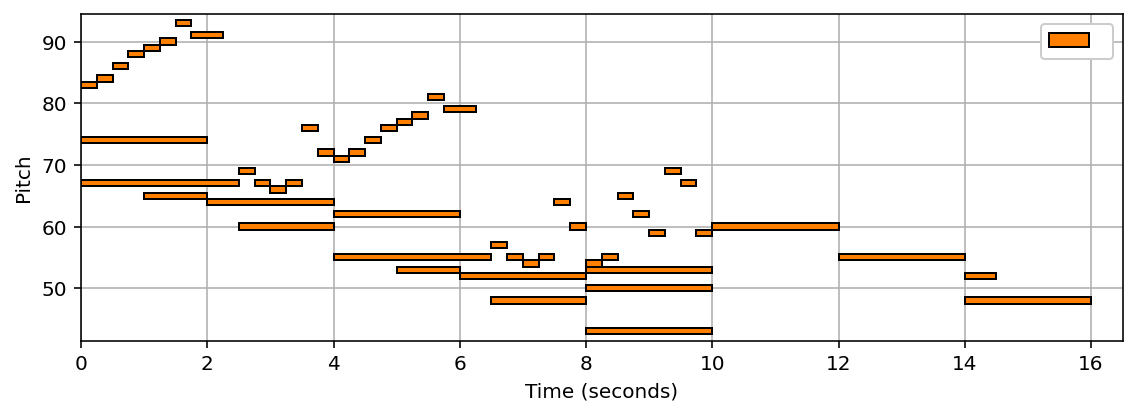

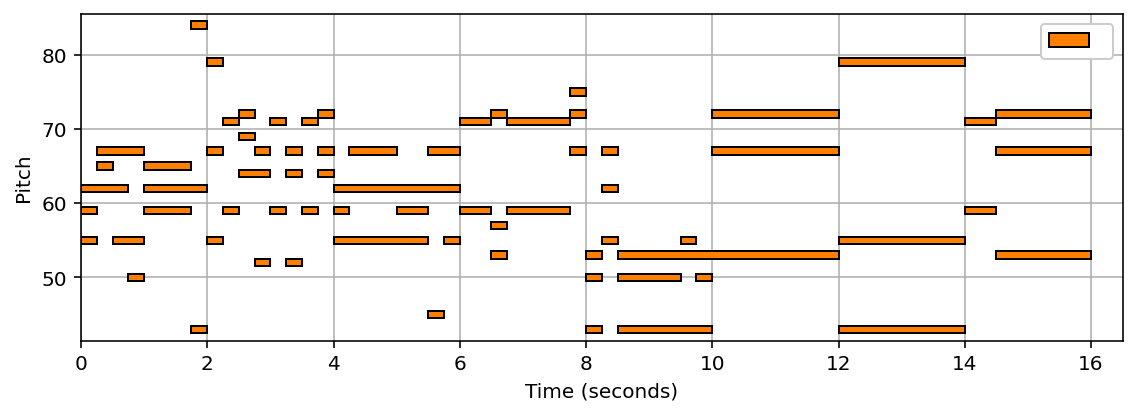

In [326]:

import IPython.display
import libfmp.c1


index = 256 ## 44 66 & 0 & 1 500 omg 1021
tranform = dataset["train"].dataset.transform["inverse_norm"]
for i,batch in enumerate(dataset["train"]): 
    if i == index: 
        original_piano_roll = tranform(batch[0])[0][0]
        x_var = batch[0].permute(0,1,3,2).to(net.device).float()
        xpred_var = net(x_var).permute(0,1,3,2) #tranform? 

        piano_roll = xpred_var[0][0].detach().cpu()
        print(piano_roll)
        piano_roll = keepTOPkpitch(piano_roll, K=3)
        piano_roll = (piano_roll>=0.2) 
        break


print("ORIGINAL ")
arr = pad88to128(original_piano_roll, org=64)
Opm = piano_roll_to_pretty_midi(arr)
IPython.display.display(IPython.display.Audio(Opm.synthesize(fs=16000), rate=16000))

Oscore = libfmp.c1.midi_to_list(Opm)
libfmp.c1.visualize_piano_roll(Oscore, figsize=(8, 3))


print("AE RECUNSTRUCTION")
arr = pad88to128(piano_roll, org=64)
pm = piano_roll_to_pretty_midi(arr)
IPython.display.display(IPython.display.Audio(pm.synthesize(fs=16000), rate=16000))

score = libfmp.c1.midi_to_list(pm)
libfmp.c1.visualize_piano_roll(score, figsize=(8, 3))



In [269]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
